In [2]:
import pandas as pd
import os
import numpy  as np
import torch


In [3]:

from torch_geometric.data import Data
data_dir = '../../datasets/m4a-onion-updated-20241210'
processed_data_dir = '../../processed_data/m4a-onion'
# read train, valid, and test datasets
train = pd.read_parquet(os.path.join(processed_data_dir, 'm4a_train.parquet'))
valid = pd.read_parquet(os.path.join(processed_data_dir, 'm4a_val.parquet'))
test = pd.read_parquet(os.path.join(processed_data_dir, 'm4a_test.parquet'))
all_df = pd.read_parquet(os.path.join(processed_data_dir, 'm4a_all.parquet'))

track_id_mapping = pd.read_parquet(os.path.join(processed_data_dir, 'm4a_track_mapping.parquet'))
track_id_mapping = {track_id: graph_track_id for _, (track_id, graph_track_id) in track_id_mapping[['track_id', 'graph_track_id']].iterrows()}
user_id_mapping = pd.read_parquet(os.path.join(processed_data_dir, 'm4a_user_mapping.parquet'))
user_id_mapping = {user_id: graph_user_id for _, (user_id, graph_user_id) in user_id_mapping[['user_id', 'graph_user_id']].iterrows()}


# read feature df
feature = pd.read_parquet(os.path.join(data_dir, 'M4A_song features_with img_Final.parquet'))
lyrics_embedding = pd.DataFrame(feature.lyrics_embedding.tolist(), columns = (lyrics_feature_cols := [f'lyrics_{i}' for i in range(768)]))
feature = feature.drop(columns = ['lyrics_embedding'])
## combine lyrics embedding with features
feature = pd.concat([feature, lyrics_embedding], axis = 1)

# Identifying features

In [4]:
import re
# get different feature columns 
id_col = ['id', 'track_id']
lyrics_features_cols = [f'lyrics_{i}' for i in range(768)]
lowlevel_audio_cols = [col for col in feature if 'lowlevel' in col]
cov_audio_cols = [col for col in feature if 'cov' in col]
mfcc_audio_cols = [col for col in feature if 'MFCC' in col]
rhythm_audio_cols = [col for col in feature if 'rhythm.' in col]
tonal_audio_cols = [col for col in feature if ('tonal' in col) and (col.lower() != 'microtonal')]
metadata_audio_cols = [col for col in  feature if 'metadata' in col]
max_image_cols = [col for col in feature if re.match(r'max\d{4}', col)]
mean_image_cols = [col for col in feature if re.match(r'mean\d{4}', col)]
highlevel_audio_cols = ['release', 'danceability', 'energy', 'key', 'mode', 'valence', 'tempo']
song_context_cols = ['popularity', 'duration_ms',]
misc_cols = [ 'artist', 'song', 'lang', 'spotify_id', 'tags', 'album_name', 'genres', '(tag, weight)', 'microtonal']
genre_cols = [col for col in feature if col not in (id_col + lyrics_features_cols + lowlevel_audio_cols + cov_audio_cols + mfcc_audio_cols + rhythm_audio_cols + tonal_audio_cols \
                                                    + metadata_audio_cols + max_image_cols + mean_image_cols +  song_context_cols + misc_cols + highlevel_audio_cols )]

# types of features to keep
lyrics_features = lyrics_features_cols # 768
audio_features = lowlevel_audio_cols + cov_audio_cols + mfcc_audio_cols + rhythm_audio_cols + tonal_audio_cols + highlevel_audio_cols + song_context_cols # 175?
image_features = mean_image_cols # 2048
# all_features = lyrics_features + audio_features + image_features
all_features = lyrics_features + audio_features + image_features


def get_features(feature, feature_cols):
    return feature[feature_cols]



In [5]:
len(mean_image_cols)

2048

# Creating Graph

## Creating feature vector 

In [6]:
feature['graph_track_id'] = feature['track_id'].map(track_id_mapping)
feature = feature.sort_values(by = 'graph_track_id')
trimmed_features = feature[all_features].values
user_features = np.zeros((len(user_id_mapping), trimmed_features.shape[1]))
node_features = torch.concat([torch.tensor(trimmed_features, dtype = torch.float32), torch.tensor(user_features, dtype = torch.float32)], dim = 0)

## Creating edge index

In [6]:
from sampling import get_aux_candidates, get_existing_edges, get_sorted_tracks_by_timestamp, sample_negative_edges

def create_graph(data, all_df, track_features, track_id_mapping, user_id_mapping, selected_features = None):
    track_features = track_features.copy()
    if selected_features is not None: # trim features to just selected features
        trimmed_features = track_features[selected_features]
    else:
        trimmed_features = track_features
    user_features = np.zeros((len(user_id_mapping), trimmed_features.shape[1])) # initialize user features to zero
    node_features = torch.concat(
        [torch.tensor(trimmed_features.values, dtype = torch.float32),
        torch.tensor(user_features, dtype = torch.float32)], dim = 0
    )  # initialize item features to trimmed_features.values
    
    existing_edges = get_existing_edges(all_df) # get set of existing edges
    ts_tracks = get_sorted_tracks_by_timestamp(all_df) # sort tracks by timestamp
    # create auxiliary candidate list for users which have less than 20 items to sample from
    aux_candidates = get_aux_candidates(track_features, track_id_mapping, release_year= 2018)
    # sample negative edges, making sure that they don't already exist, and that it has been listened to *at least once* before this event.
    users, pos_edge_index, neg_edge_index = sample_negative_edges(data, ts_tracks, existing_edges, aux_candidates)
    
    # get edge arrays
    pos_edge_array = np.array(pos_edge_index)
    neg_edge_array = np.array(neg_edge_index)
    
    # construct undirected graph
    u_t, i_t = (
        torch.tensor(pos_edge_array[:, 0 ]),
        torch.tensor(pos_edge_array[:, 1])
    )
    edge_index = torch.stack((torch.cat([u_t, i_t]), torch.cat([i_t, u_t])), dim=0)
    # return graph object, as well as positive and negative nodes
    graph = Data(x = node_features, edge_index = edge_index)
    return graph, pos_edge_array, neg_edge_array

full_graph, full_positive_edges, full_negative_edges = create_graph(all_df, all_df, feature, track_id_mapping, user_id_mapping, selected_features = all_features)
    

In [8]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
import random 

class MultimodalFeatureFusion(torch.nn.Module):
    def __init__(self, feature_dims, projection_dim):
        super(MultimodalFeatureFusion, self).__init__()
        
        self.feature_dims = feature_dims
        
        # Create projection layers for each modality
        self.projections = torch.nn.ModuleDict({
            name: torch.nn.Linear(dim, projection_dim) 
            for name, dim in feature_dims.items()
        })
        
        # Create attention weights vector for each modality
        # self.attention = torch.nn.Linear(projection_dim, 1, bias=False)
        self.attention = torch.nn.Linear(projection_dim, 1, bias=False)
        self.reset_parameters()

    def reset_parameters(self):
        for name, projection in self.projections.items():
            torch.nn.init.xavier_uniform_(projection.weight)
        torch.nn.init.xavier_uniform_(self.attention.weight)
    
    def forward(self, features_dict): # forward(self, lyrics_features, audio_features, image_features)
        
        projected_features = {}
        attention_weights = {}
        
        for name, features in features_dict.items():
            projected = self.projections[name](features) # get projection (for modality vector we are interested in)
            projected = F.relu(projected) # apply non-linearity
            attention_score = self.attention(projected) # apply attention weights -> results in n x 1 attention score
            projected_features[name] = projected  # add projected vector to dict 
            attention_weights[name] = attention_score
        
        # Softmax over attention weights for 0-1 prob
        attention_weights = torch.cat([w for w in attention_weights.values()], dim=1) # concatenate all attention scores
        attention_weights = F.softmax(attention_weights, dim=1) # softmax
        
        # Combine features with weights to get attn output
        combined_features = torch.zeros_like(projected) # zeros_like makes sure that the vector is also on `device`
                                                        # additionally all `projected` vectors are the same dimension
        for idx, (name, features) in enumerate(projected_features.items()):
            combined_features += features * attention_weights[:, idx:idx+1]
            
        return combined_features

class MultimodalGAT(torch.nn.Module):
    def __init__(self, feature_dims, projection_dim, hidden_dim=256, num_heads=4, num_layers=3, dropout=0.5):
        super(MultimodalGAT, self).__init__()
        
        self.feature_dims = feature_dims
        # Feature fusion layer
        self.fusion = MultimodalFeatureFusion(feature_dims, projection_dim=projection_dim) # projection_dim = hidden_dim for simplicity?
        

        # create GAT layers
        self.gat_layers = torch.nn.ModuleList()
        self.gat_layers.append(GATConv(projection_dim, hidden_dim, heads=num_heads, dropout=dropout))
        for i in range(num_layers - 2):
            self.gat_layers.append(
                GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, dropout=dropout)
            )
        self.gat_layers.append(
            GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, dropout=dropout)
        ) 
        self.dropout = dropout
        


    def forward(self, data):
        # Split features into modalities - lyrics, audio, and image using feature_dims
        x = data.x
        
        lyrics_dim = self.feature_dims['lyrics']
        audio_dim = self.feature_dims['audio']
        image_dim = self.feature_dims['image']
        
        lyrics_x = x[:, :lyrics_dim]
        audio_x = x[:, lyrics_dim: lyrics_dim+audio_dim]
        image_x = x[:, lyrics_dim+audio_dim: lyrics_dim+audio_dim+image_dim]

        features_dict = {
            'lyrics': lyrics_x,
            'audio': audio_x,
            'image': image_x
        }

        # Fuse features with attention (defined above)
        x = self.fusion(features_dict)
        
        # Apply GAT layers
        for i, layer in enumerate(self.gat_layers[:-1]):
            x = layer(x, data.edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Final layer
        x = self.gat_layers[-1](x, data.edge_index)
        
        return x
    
#### DELETE #####
# feature_dims = {
#     'lyrics': len(lyrics_features),
#     'audio': len(audio_features),
#     'image': len(image_features)
# }
# device = 'cuda'    
# model = MultimodalGAT(
#     feature_dims=feature_dims,
#     projection_dim = 256,
#     hidden_dim=256,
#     num_heads=4,
#     num_layers=3,
#     dropout=0.5
# )
# model.to(device)
# full_graph.to(device)
# model(full_graph)

In [9]:
from tqdm import tqdm
num_users = len(user_id_mapping)
num_tracks = len(track_id_mapping)
print("num_users:", num_users)
print("num_tracks:", num_tracks)# BPR loss function



import random as rd
from sampling import get_aux_candidates, get_existing_edges, get_sorted_tracks_by_timestamp, sample_negative_edges

def compute_bpr_loss(users_emb, pos_emb, neg_emb, lambda_reg=1e-4):
    # Compute the standard BPR loss
    pos_scores = (users_emb * pos_emb).sum(dim=1)  # Dot product for positive pairs
    neg_scores = (users_emb * neg_emb).sum(dim=1)  # Dot product for negative pairs

    # BPR loss
    bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

    reg_loss = (users_emb.norm(2).pow(2) +
                pos_emb.norm(2).pow(2) +
                neg_emb.norm(2).pow(2)) / users_emb.size(0)

    # Add regularization term scaled by lambda_reg (decay)
    total_loss = bpr_loss + lambda_reg * reg_loss
    return total_loss


import numpy as np
import torch

def get_mrr(user_embs, track_embs, num_tracks, test, all_data, test_candidates = None):
  relevance_score = torch.matmul(user_embs, torch.transpose(track_embs, 0, 1))

  def sample_mrr_candidates(all_pos_tracks, pos_track, num_candidates):
    candidates = []
    candidates.append(pos_track)
    while len(candidates) < num_candidates:
      candidate = rd.choice(range(num_tracks))
      if candidate not in candidates and candidate not in all_pos_tracks:
        candidates.append(candidate)
    return candidates

  mrr = []

  for test_user, group in test.groupby('graph_user_id'):
    all_pos_tracks = all_data.loc[all_data['graph_user_id'] == test_user, 'graph_track_id']

    for test_track in group['graph_track_id']:
      # the first candidate is the positive one
      if test_candidates is None:
        candidates = sample_mrr_candidates(all_pos_tracks, test_track, num_candidates=20)
      else: 
        candidates = test_candidates[test_track]
      user_scores =  relevance_score[test_user-num_tracks, candidates].clone()
      sorted_indices = torch.argsort(user_scores, descending=True)
      # the positive track is always the first in candidates list
      rank = sorted_indices.tolist().index(0) + 1
      reciprocal_rank = 1.0 / rank
      mrr.append(reciprocal_rank)

  return sum(mrr)/len(mrr)


num_users: 2312
num_tracks: 32685


In [185]:
HIDDEN_DIM = 64
N_LAYERS = 2
EPOCHS = 30
BATCH_SIZE = 1024
DECAY = 0.0004
LR = 0.0001
K = 20

In [186]:
from ray import tune
from ray.train import report
from ray.tune.schedulers import ASHAScheduler
device = 'cuda'

feature_dims = {
    'lyrics': len(lyrics_features),
    'audio': len(audio_features),
    'image': len(image_features)
}



def train_tune(config, train, valid, all_df, feature, track_id_mapping, user_id_mapping, all_features, hyperparam = False):    
    num_users = len(user_id_mapping)
    num_tracks = len(track_id_mapping)T
    
    model = MultimodalGAT(
        **config['model_params']
    )
    model.to(config['device'])
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    # Training settings
    patience = config['patience'] #  Number of epochs to wait for improvement before stopping
    early_stopping_counter = 0
    best_validation_loss = float('inf')
    
    model.train()  # Ensure the model is in training mode
    
    train_losses = []
    valid_losses = []
    valid_mrr = []
    for epoch in range(EPOCHS):
        if epoch % 3 == 0:
            train_graph, train_positive_edges, train_negative_edges = create_graph(train, all_df, feature, track_id_mapping, user_id_mapping, selected_features = all_features)
            valid_graph, valid_positive_edges, valid_negative_edges = create_graph(valid, all_df, feature, track_id_mapping, user_id_mapping, selected_features = all_features)
            train_graph.to(config['device'])
            valid_graph.to(config['device'])
        # Training step
        optimizer.zero_grad()
        edge_out = model(train_graph)
        user_nodes = train_positive_edges[:, 0]
        pos_nodes = train_positive_edges[:, 1]
        neg_nodes = train_negative_edges[:, 1]
        train_loss = compute_bpr_loss(edge_out[user_nodes], edge_out[pos_nodes], edge_out[neg_nodes], lambda_reg=config['decay'])
        train_loss.backward()
        optimizer.step()
    
        # Validation step
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            val_out = model(valid_graph).cpu()
            user_nodes = valid_positive_edges[:, 0]
            pos_nodes = valid_positive_edges[:, 1]
            neg_nodes = valid_negative_edges[:, 1]
            val_loss = compute_bpr_loss(val_out[user_nodes], val_out[pos_nodes], val_out[neg_nodes], lambda_reg=config['decay'])
            user_map = [val for val in user_id_mapping.values()]
            item_map = [val for val in track_id_mapping.values()]
            mrr = get_mrr(val_out[user_map], val_out[item_map], num_tracks, valid, all_df)
    
            # Store losses for plotting
        train_losses.append(train_loss.item())
        valid_losses.append(val_loss.item())
        valid_mrr.append(mrr)
        
        model.train()  # Set the model back to training mode
    
        if patience is not None:
            # Early stopping logic
            if val_loss < best_validation_loss:
                best_validation_loss = val_loss
                early_stopping_counter = 0  # Reset counter if validation loss improves
            else:
                early_stopping_counter += 1
                if early_stopping_counter >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
        
        # Print losses for each epoch
        if hyperparam:
            report({'train_loss':float(train_loss.item()), 'val_loss':  float(val_loss.item()), 'val_mrr': float(mrr)})
        else:
            print(f"Epoch: {epoch}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}, MRR: {mrr}")
    if not hyperparam:
        return model, train_losses, valid_losses, valid_mrr


In [145]:
search_space = {
    'model_params': {
        'feature_dims': {                                  
        'lyrics': len(lyrics_features),               
        'audio': len(audio_features),                 
        'image': len(image_features)                  
        },                                                                               
    "projection_dim"  :  tune.grid_search([64, 128]),
    "hidden_dim" :  tune.grid_search([64, 128]),
    "num_heads" : tune.grid_search([2,3,4]),
    "num_layers" : 3,
    "dropout" : 0.5 
    }, 
    'epochs': 30,
    'decay': 1e-3,
    'lr': tune.grid_search([1e-5,1e-3,1e-2]),
    'patience': None,
    'device': 'cuda'
}


In [ ]:
from ray.tune.schedulers import ASHAScheduler
import ray
import warnings

import logging
ray.init(logging_level=logging.ERROR)

logging.basicConfig(level=logging.CRITICAL) 
# This will only show critical messages

scheduler = ASHAScheduler(
    metric="val_loss", mode="min", max_t=100, grace_period=10, reduction_factor=2
)

# Code that might raise warnings
analysis = tune.run(
    tune.with_parameters(
        train_tune,
        train=train,
        valid=valid,
        all_df=all_df,
        feature=feature,
        track_id_mapping=track_id_mapping,
        user_id_mapping=user_id_mapping,
        all_features=all_features,
        hyperparam = True,
    ),
    resources_per_trial={"cpu": 7, "gpu": 0.25},  # Adjust based on your setup
    config=search_space,
    num_samples = 2,  # Number of hyperparameter configurations to try
    scheduler=scheduler,
    raise_on_failed_trial = False

)
# Get the best hyperparameter configuration
best_config = analysis.get_best_config(metric="val_mrr", mode="max")
print("Best config: ", best_config)


In [ ]:
analysis.get_best_config(metric=  'val_loss', mode= 'min', scope= 'last-10-avg')
print(analysis.get_best_trial(metric=  'val_loss', mode= 'min', scope= 'last-10-avg'))

In [228]:
best_config = {
    'model_params': {
        'feature_dims': {                                  
        'lyrics': len(lyrics_features),               
        'audio': len(audio_features),                 
        'image': len(image_features)                  
        },                                                                               
    "projection_dim"  :  64,
    "hidden_dim" :  128,
    "num_heads" : 2,
    "num_layers" : 3,
    "dropout" : 0.5 
    }, 
    'epochs': 30,
    'decay': 0.001,
    'lr': 0.001,
    'patience': None,
    'device': 'cuda'
}

In [229]:
import random
best_model, train_losses, valid_losses, valid_mrr = train_tune(best_config, train, valid, all_df, feature, track_id_mapping, user_id_mapping, all_features, hyperparam = False)

Epoch: 0, Training Loss: 0.9206196665763855, Validation Loss: 0.7950640916824341, MRR: 0.46427569324942597
Epoch: 1, Training Loss: 0.8681020736694336, Validation Loss: 0.7125665545463562, MRR: 0.4730967959970215
Epoch: 2, Training Loss: 0.8674752712249756, Validation Loss: 0.6906409859657288, MRR: 0.4810660204966856
Epoch: 3, Training Loss: 0.8665043711662292, Validation Loss: 0.6961522698402405, MRR: 0.4815324836308263
Epoch: 4, Training Loss: 0.860885739326477, Validation Loss: 0.7169514894485474, MRR: 0.48186929449484533
Epoch: 5, Training Loss: 0.8567306399345398, Validation Loss: 0.7413879632949829, MRR: 0.47938664131013214
Epoch: 6, Training Loss: 0.853488028049469, Validation Loss: 0.7634359002113342, MRR: 0.47512543473233837
Epoch: 7, Training Loss: 0.8521665334701538, Validation Loss: 0.7758470773696899, MRR: 0.47316873637705137
Epoch: 8, Training Loss: 0.8499855995178223, Validation Loss: 0.7795937061309814, MRR: 0.4739659334025973
Epoch: 9, Training Loss: 0.84967041015625, 

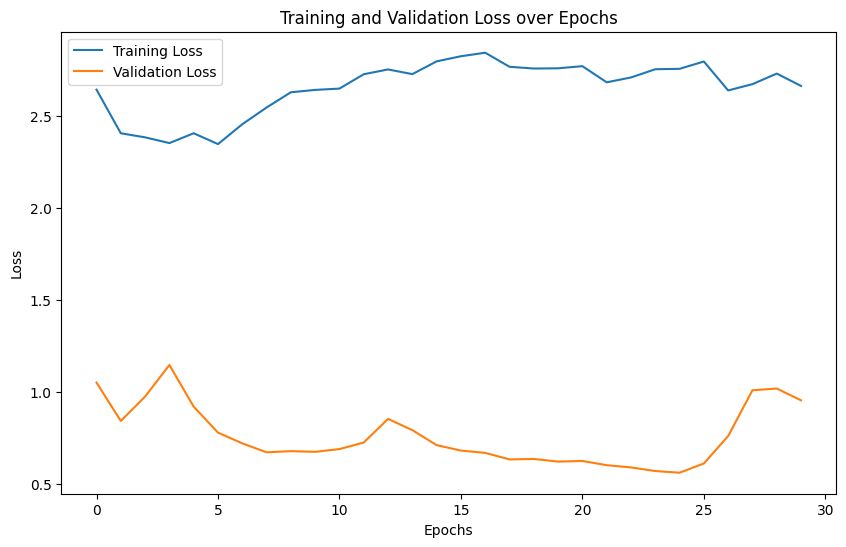

In [220]:
import matplotlib.pyplot as plt
# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()


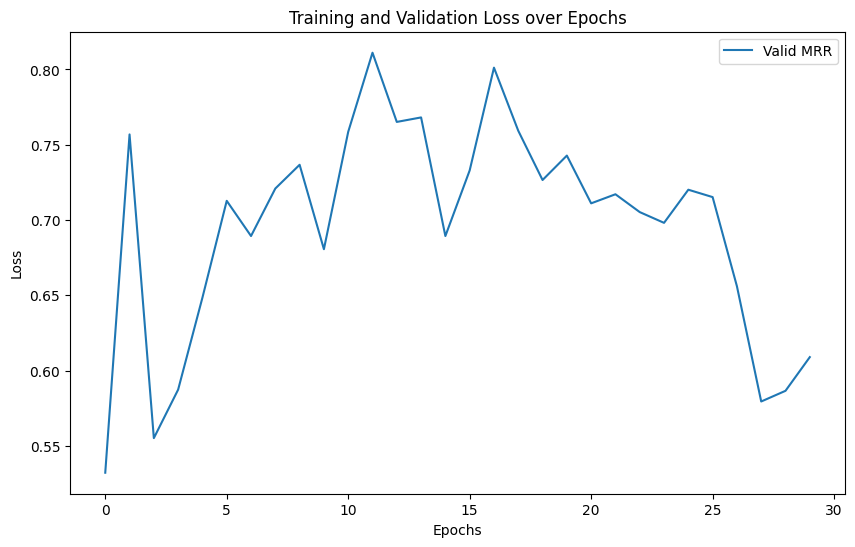

In [221]:
import matplotlib.pyplot as plt
# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(valid_mrr, label='Valid MRR')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()


Save results

In [1]:
import pandas as pd
import zipfile
import pickle

results_folder = '../../models/'



def eval_results(test, model):
    # CHANGE THIS FOR LIGHTGCN
    
    test_graph, test_positive_edges, test_negative_edges = create_graph(test, all_df, feature, track_id_mapping, user_id_mapping, selected_features = all_features)
    test_graph.to(device)
    model.eval()
    test_candidates = {graph_track_id: test_cand_list for _, (graph_track_id, test_cand_list) in test[['graph_track_id', 'test_candidates']].iterrows()}
    with torch.no_grad():
        user_map = [val for val in user_id_mapping.values()]
        item_map = [val for val in track_id_mapping.values()]
        test_out = model(test_graph).cpu()
        mrr = get_mrr(test_out[user_map], test_out[item_map], num_tracks, test, all_df, test_candidates = test_candidates)
    return mrr
    
def get_results(test_res, valid_res_list, valid_loss_list, train_loss_list):
    df = pd.DataFrame({
        'test_result': [test_res],
        'valid_results': [valid_res_list],
        'valid_losses': [valid_loss_list],
        'train_losses': [train_loss_list]
    })
    return df

def zip_dataframe_and_model(df, model, folder_path, zip_filename):
    """
    Zips a Pandas DataFrame and a model into a specified folder.

    Args:
        df (pd.DataFrame): The DataFrame to zip.
        model: The model object to zip.
        folder_path (str): The path to the folder where the zip file will be created.
        zip_filename (str): The name of the zip file.
    """
    
    with zipfile.ZipFile(f"{folder_path}/{zip_filename}", 'w') as zipf:
        # Save DataFrame to CSV and add to zip
        df.to_csv("results.csv", index=False)
        zipf.write("results.csv")

        # Save model to pickle and add to zip
        with open("model.pkl", 'wb') as model_file:
            pickle.dump(model, model_file)
        zipf.write("model.pkl")
        
test_mrr = eval_results(test, best_model)
results_df = get_results(test_mrr, valid_mrr, valid_losses, train_losses)
zip_dataframe_and_model(results_df, best_model, folder_path = results_folder, zip_filename ='results/ray_tune_1_2_headed_fusion_gat_model_all_features')

NameError: name 'test' is not defined

In [10]:
import pandas as pd
import zipfile
import pickle
import os

def extract_model_and_results(zip_filepath):

    # Create a temporary directory to extract files
    temp_dir = "temp_extract"
    os.makedirs(temp_dir, exist_ok=True)
    
    try:
        with zipfile.ZipFile(zip_filepath, 'r') as zipf:
            zipf.extractall(temp_dir)
            results_df = pd.read_csv(os.path.join(temp_dir, "results.csv"))
            with open(os.path.join(temp_dir, "model.pkl"), 'rb') as model_file:
                model = pickle.load(model_file)
                
        return results_df, model
        
    finally:
        if os.path.exists(os.path.join(temp_dir, "results.csv")):
            os.remove(os.path.join(temp_dir, "results.csv"))
        if os.path.exists(os.path.join(temp_dir, "model.pkl")):
            os.remove(os.path.join(temp_dir, "model.pkl"))
        if os.path.exists(temp_dir):
            os.rmdir(temp_dir)

# Example usage:
zip_path = "../../models/ray_tune_1_2_headed_fusion_gat_model_all_features"
results_df, loaded_model = extract_model_and_results(zip_path)

In [11]:
results_df

,test_result,valid_results,valid_losses,train_losses
0,0.837171,"[0.07643768963397071, 0.09179208780448868, 0.5...","[1.0815205574035645, 0.7639524340629578, 0.523...","[0.7663599252700806, 0.7513419985771179, 0.745..."


0


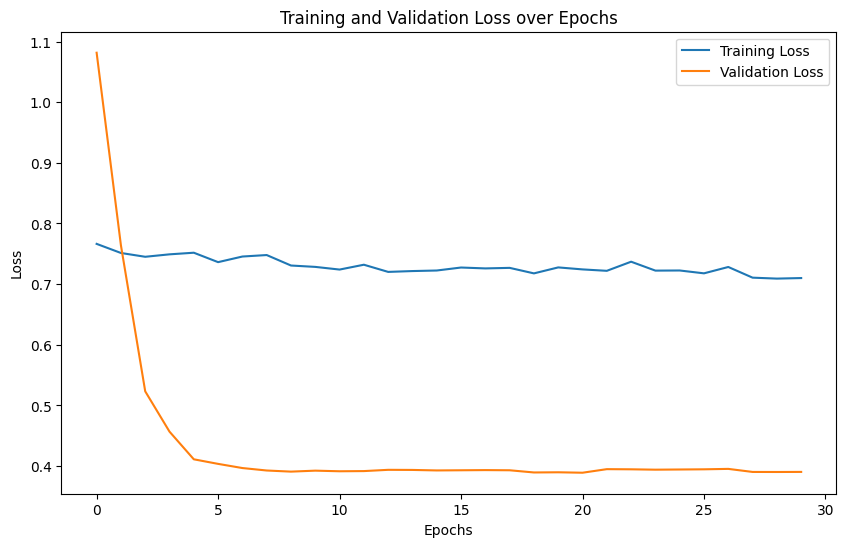

C:\Users\Gaurav Anand\AppData\Local\Temp\ipykernel_37744\1183506837.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


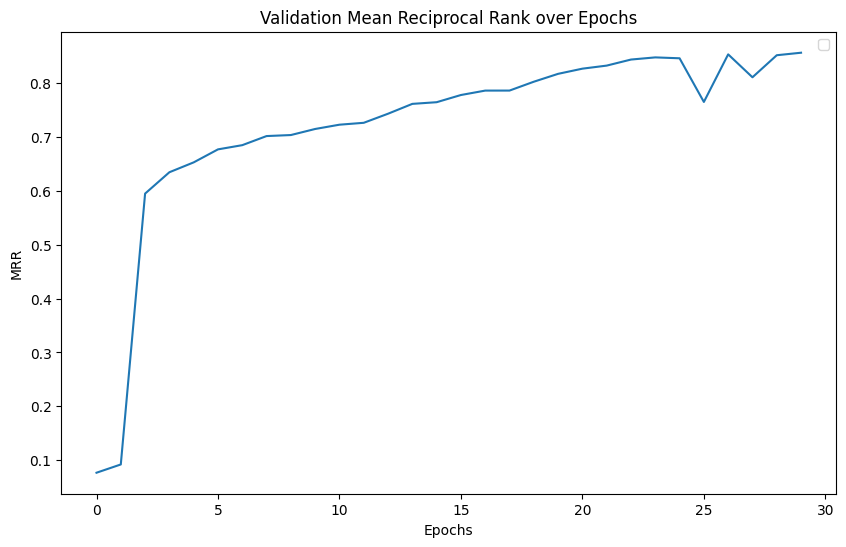

In [14]:
for i, (test_result, valid_results, valid_losses, train_losses) in results_df.iterrows():
    print(i)
    
valid_mrr = [float(x) for x in valid_results.strip('[').strip(']').split(',')]
valid_losses = [float(x) for x in valid_losses.strip('[').strip(']').split(',')]
train_losses = [float(x) for x in train_losses.strip('[').strip(']').split(',')]

import matplotlib.pyplot as plt
# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()

import matplotlib.pyplot as plt
# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(valid_mrr)
# plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MRR')
plt.legend()
plt.title('Validation Mean Reciprocal Rank over Epochs')
plt.show()

